In [12]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib
import scipy
import pandas as pd
from PIL import Image
import os
from skimage.feature import peak_local_max
import imageio
from scipy.optimize import curve_fit
import itertools


%matplotlib qt

#maxdose=18
maxdose=18
energy=200


font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 30}


matplotlib.rc('font', **font)


#Get and calibrate films################################################################3
film_r=[]
film_g=[]
film_b=[]
directory = 'D:/Desktop/thesis/GRID at CERN/GRID/10_11_22/10_11_22_3dayscans/'
for i in np.arange(1,11+1):
    input_image = np.array(Image.open(directory+'film00'+str(i)+'.tif').convert("RGB")).T
    film_r.append(input_image[0].T)
    film_g.append(input_image[1].T)
    film_b.append(input_image[2].T)
#apply calibration corrections
#Joe's values 
a_r = 1.08979454e-02;b_r = 4.31528862e-04;c_r = 4.52890034e+00
a_g = 1.30365440e-02;b_g = 2.18523305e-04;c_g = 5.47818342e+00
a_b = 1.83975349e-02;b_b = 4.03633386e-04;c_b = 1.10176866e+01


film_r=np.array(film_r)/65535
film_r=np.array([(a_r - c_r * i) / (i - b_r) for i in film_r])
film_g=np.array(film_g)/65535
film_g=np.array([(a_g - c_g * i) / (i - b_g) for i in film_g])
film_b=np.array(film_b)/65535
film_b=np.array([(a_b - c_b * i) / (i - b_b) for i in film_b])
###########################################################################################

#Background films
background=[np.array(Image.open(directory+'film_bkg0'+str(i)+'.tif').convert("RGB")).T for i in np.arange(34,37)]
input_image = np.mean(background,axis=0)
bkg_r=np.array([input_image[0].T]).squeeze()
bkg_g=np.array([input_image[1].T]).squeeze()
bkg_b=np.array([input_image[2].T]).squeeze()

bkg_r=np.array(bkg_r)/65535
bkg_r=np.array([(a_r - c_r * i) / (i - b_r) for i in bkg_r]).clip(min=0)
bkg_g=np.array(bkg_g)/65535
bkg_g=np.array([(a_g - c_g * i) / (i - b_g) for i in bkg_g]).clip(min=0)
bkg_b=np.array(bkg_b)/65535
bkg_b=np.array([(a_b - c_b * i) / (i - b_b) for i in bkg_b]).clip(min=0)

bkg_dose_r=np.mean(bkg_r[100:300,100:300])
bkg_dose_g=np.mean(bkg_g[100:300,100:300])
bkg_dose_b=np.mean(bkg_b[100:300,100:300])

figure(1)
plt.imshow(bkg_g[100:300,100:300])
plt.colorbar()
###############################################################################

#Open beam analysis
OB=np.array(film_g-bkg_dose_g)#/(6.8e-9/0.3) #factor is total charge/charge per bunch/rep rate
OBxfilm=np.arange(13,63+1,5) ########### film locations

# OBpeaks=[]
# OBpeaks_err=[]
# profiles1d=[]
# for k in range(len(OB)):
#     #find indices of maxima
#     xy=[]
#     xy = peak_local_max(scipy.ndimage.gaussian_filter(OB[k,100:300,100:300],sigma=10),threshold_abs=2,num_peaks=1)
#     xy=[xy[0,1]+100,xy[0,0]+100]
#     if k==0:
#         OBfirstpeak=xy[1]
#     print(xy)
#     #plot 2d profiles
#     figure(k+80,figsize=(8,8))
#     profile=OB[k,xy[1]-125:xy[1]+126,xy[0]-125:xy[0]+126]
#     im=plt.imshow(profile,vmin=0,vmax=maxdose,cmap='inferno',extent=(0,len(profile)/300*25.4,0,len(profile)/300*25.4))
#     plt.colorbar(label='Dose rate (Gy/s)',fraction=0.046, pad=0.04)
#     plt.scatter(125/300*25.4,125/300*25.4,s=20,c='red')
#     plt.text(16,19.5,str(OBxfilm[k])+'mm',c='white')
#     plt.text(8.7,19.5,str(energy)+'MeV',c='white')
#     plt.xlabel('x (mm)')
#     plt.ylabel('y (mm)')
#     plt.savefig('D:Desktop/thesis/film_analysis/OB'+str(k)+'_'+str(energy)+'.png')
#     profiles1d.append(np.mean([OB[k,i] for i in np.arange(xy[1]-10,xy[1]+11)],axis=0))
    
#     #ROI for PDDs
#     OBpeaks.append(np.mean([OB[k,i,j] for i in np.arange(xy[1]-10,xy[1]+10) for j in np.arange(xy[0]-10,xy[0]+10)]))
#     OBpeaks_err.append(np.std([OB[k,i,j] for i in np.arange(xy[1]-10,xy[1]+10) for j in np.arange(xy[0]-10,xy[0]+10)])/np.sqrt(len([OB[k,i,j] for i in np.arange(xy[1]-10,xy[1]+10) for j in np.arange(xy[0]-10,xy[0]+10)])))
# OBpeaks=np.array(OBpeaks)
# OBpeaks_err=np.array(OBpeaks_err)

# #animation
# frames=[]
# for k in range(len(OB)):
#     frames.append(imageio.imread('D:Desktop/thesis/film_analysis/OB'+str(k)+'_'+str(energy)+'.png'))
# imageio.mimsave('D:Desktop/thesis/film_analysis/OB'+str(energy)+'.gif', frames,'GIF-FI',quantizer='nq',duration=0.5)

# print('background dose='+str(bkg_dose_g))

# #Gaussian fit
# def gaus(x,a,x0,sigma):
#     return a*np.exp(-(x-x0)**2/(2*sigma**2))

# def gauss_fit(xdata,ydata):
#     mean = sum(xdata * ydata) / sum(ydata)
#     sigma = np.sqrt(sum(ydata * (xdata - mean)**2) / sum(ydata))
#     popt,pcov = curve_fit(gaus,xdata,ydata,p0=[max(ydata), mean, sigma])
#     #plt.plot(np.arange(0,len(ydata))+(124-100),gaus(xdata,*popt),label='Gaussian fit',lw=3)
#     return popt[-1],np.sqrt(np.diag(pcov))[-1]
    

# savethis=np.array([OB,OBxfilm,OBpeaks,OBpeaks_err,np.arange(0,len(OB[0,OBfirstpeak]))/300*25.4,profiles1d],dtype=object)
# np.save('D:Desktop/thesis/200MeVOB.npy',savethis)


figure(69)
plt.imshow(OB[1],vmax=10)
plt.colorbar()

In [6]:
x=np.arange(0,414)/300*25.4
y=np.arange(0,475)/300*25.4
sigmax=[]
sigmay=[]
for i in np.arange(0,11):
    #print(peakindices[i,1])
    sigmax.append(gauss_fit(x[90:350],OB[i,peakindices[i,1],90:350]))
    sigmay.append(gauss_fit(y[90:400],OB[i,90:400,peakindices[i,0]]))
sigmax=np.array(sigmax)
sigmay=np.array(sigmay)
    
# figure(1,figsize=(8,8))
# plt.plot(OBxfilm,sigmax,label='X sigma',marker='o')
# plt.plot(OBxfilm,sigmay,label='Y sigma',marker='o')
# plt.grid(c='lightgray')
# plt.legend()
# plt.ylabel('Sigma (mm)')
# plt.xlabel('Depth (mm)')

np.save('D:Desktop/thesis/filmsigmax.npy',sigmax)
np.save('D:Desktop/thesis/filmsigmay.npy',sigmay)

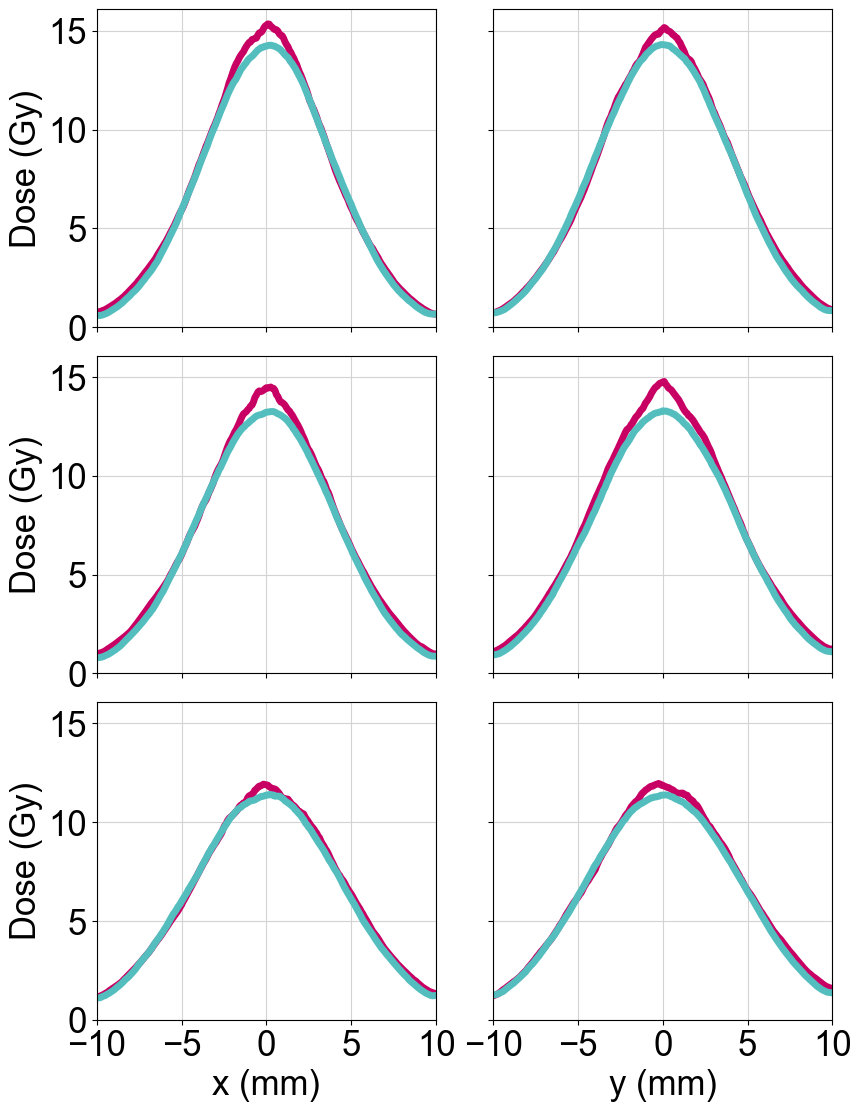

In [54]:
from skimage.filters import rank
%matplotlib inline
font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 25}

matplotlib.rc('font', **font)
matplotlib.rcParams['axes.prop_cycle'] = matplotlib.cycler(color=["#c80064","#54bebe"])



peakindices=np.array([[203, 257],[200, 251],[201, 250],[204, 250],[201, 248],[206, 251],[210, 251],[199, 248],[203, 252],[209, 250],[204, 248]])
simgaussx1=np.load('D:Desktop/thesis/sims_gauss_x1.npy')
simgaussy1=np.load('D:Desktop/thesis/sims_gauss_y1.npy')
simgaussx3=np.load('D:Desktop/thesis/sims_gauss_x3.npy')
simgaussy3=np.load('D:Desktop/thesis/sims_gauss_y3.npy')
simgaussx2=np.load('D:Desktop/thesis/sims_gauss_x2.npy')
simgaussy2=np.load('D:Desktop/thesis/sims_gauss_y2.npy')


fig, ax = plt.subplots(3, 2, figsize=(8.5,11),sharex=True,sharey=True,constrained_layout=True)
ax[0,0].plot((np.arange(0,len(OB[0,257,203-120:203+120]))-120)/300*25.4,scipy.ndimage.uniform_filter(np.mean(OB[0,257-1:257+2,203-120:203+120],axis=0),size=15),label='Film',lw=5)
ax[0,0].plot(np.arange(0,len(simgaussx1))*0.1-10,scipy.ndimage.uniform_filter(simgaussx1,size=15),label='Simulation',lw=5)



ax[0,1].plot((np.arange(0,len(OB[0,257-120:257+120,203]))-120)/300*25.4,scipy.ndimage.uniform_filter(np.mean(OB[0,257-120:257+120,203-1:203+2],axis=1),size=15),lw=5)
ax[0,1].plot(np.arange(0,len(simgaussy1))*0.1-10,scipy.ndimage.uniform_filter(simgaussy1,size=15),lw=5)



ax[1,0].plot((np.arange(0,len(OB[4,248,201-120:201+120]))-120+1)/300*25.4,scipy.ndimage.uniform_filter(np.mean(OB[4,248-1:248+2,201-120:201+120],axis=0),size=15),lw=5)
ax[1,0].plot(np.arange(0,len(simgaussx3))*0.1-10,scipy.ndimage.uniform_filter(simgaussx3,size=15),lw=5)


ax[1,1].plot((np.arange(0,len(OB[4,248-120:248+120,201]))-120-1)/300*25.4,scipy.ndimage.uniform_filter(np.mean(OB[4,248-120:248+120,201-1:201+2],axis=1),size=15),lw=5)
ax[1,1].plot(np.arange(0,len(simgaussy3))*0.1-10,scipy.ndimage.uniform_filter(simgaussy3,size=15),lw=5)


ax[2,0].plot((np.arange(0,len(OB[-1,248,204-120:204+120]))-120)/300*25.4,scipy.ndimage.uniform_filter(np.mean(OB[-1,248-1:248+2,204-120:204+120],axis=0),size=15),lw=5)
ax[2,0].plot(np.arange(0,len(simgaussx2))*0.1-10,scipy.ndimage.uniform_filter(simgaussx2,size=15),lw=5)


ax[2,1].plot((np.arange(0,len(OB[-1,248-120:248+120,204]))-120)/300*25.4,scipy.ndimage.uniform_filter(np.mean(OB[-1,248-120:248+120,204-1:204+2],axis=1),size=15),lw=5)
ax[2,1].plot(np.arange(0,len(simgaussy2))*0.1-10,scipy.ndimage.uniform_filter(simgaussy2,size=15),lw=5)

ax[0,0].set_ylabel('Dose (Gy)')
ax[1,0].set_ylabel('Dose (Gy)')
ax[2,0].set_ylabel('Dose (Gy)')

ax[2,0].set_xlabel('x (mm)')
ax[2,1].set_xlabel('y (mm)')

for row in ax:
    for col in row:
        col.grid(c='lightgray')
        col.set_ylim(0,)
        col.set_xlim(-10,10)
        col.set_xticks([-10,-5,0,5,10])
#fig.legend(ncol=2)
#fig.tight_layout()

In [47]:
maxdose=18
energy=200
%matplotlib qt
#Get and calibrate films#########################################
film_r=[]
film_g=[]
film_b=[]
directory = 'D:/Desktop/thesis/GRID at CERN/GRID/10_11_22/'

for i in np.arange(22,32+1):
    input_image = np.array(Image.open(directory+'film0'+str(i)+'.tif').convert("RGB")).T
    film_r.append(input_image[0].T)
    film_g.append(input_image[1].T)
    film_b.append(input_image[2].T)
#apply calibration corrections
#Joe's values 
a_r = 1.08979454e-02;b_r = 4.31528862e-04;c_r = 4.52890034e+00
a_g = 1.30365440e-02;b_g = 2.18523305e-04;c_g = 5.47818342e+00
a_b = 1.83975349e-02;b_b = 4.03633386e-04;c_b = 1.10176866e+01


film_r=np.array(film_r)/65535
film_r=np.array([(a_r - c_r * i) / (i - b_r) for i in film_r])
film_g=np.array(film_g)/65535
film_g=np.array([(a_g - c_g * i) / (i - b_g) for i in film_g])
film_b=np.array(film_b)/65535
film_b=np.array([(a_b - c_b * i) / (i - b_b) for i in film_b])
#########################################################################

#Background films
background=[np.array(Image.open(directory+'bkg_0'+str(i)+'.tif').convert("RGB")).T for i in np.arange(33,44)]
input_image = np.mean(background,axis=0)
bkg_r=np.array([input_image[0].T]).squeeze()
bkg_g=np.array([input_image[1].T]).squeeze()
bkg_b=np.array([input_image[2].T]).squeeze()

bkg_r=np.array(bkg_r)/65535
bkg_r=np.array([(a_r - c_r * i) / (i - b_r) for i in bkg_r]).clip(min=0)
bkg_g=np.array(bkg_g)/65535
bkg_g=np.array([(a_g - c_g * i) / (i - b_g) for i in bkg_g]).clip(min=0)
bkg_b=np.array(bkg_b)/65535
bkg_b=np.array([(a_b - c_b * i) / (i - b_b) for i in bkg_b]).clip(min=0)

bkg_dose_r=np.mean(bkg_r[100:300,100:300])
bkg_dose_g=np.mean(bkg_g[100:300,100:300])
bkg_dose_b=np.mean(bkg_b[100:300,100:300])

figure(1)
plt.imshow(bkg_g[100:300,100:300])
plt.colorbar()

##########################################

#GRID 200 MeV
GRID=np.flip(film_g-bkg_dose_g)#/(2.73e-8)
xfilm=np.arange(13,63+1,5) ######### film locations

peaks=[]
peaks_std=[]
valleys=[]
valleys_std=[]
for k in range(len(GRID)):
    
    #Find peak indices
    xy = peak_local_max(scipy.ndimage.gaussian_filter(GRID[k,100:300,100:300],sigma=3),threshold_abs=1,num_peaks=1)
    xy=[xy[0,1]+100,xy[0,0]+100]
    if k==0:
        firstpeak=xy[1]
    #plot 2d profiles
    figure(k+30,figsize=(8,8))
    profile=GRID[k,xy[1]-125:xy[1]+126,xy[0]-125:xy[0]+126]
    plt.imshow(GRID[k],vmin=0,vmax=maxdose,cmap='inferno')#,extent=(0,len(profile)/300*25.4,0,len(profile)/300*25.4))
    plt.colorbar(shrink=0.6,label='Dose (Gy)')
    #plt.scatter(125,125,s=20,c='red')
    plt.text(16,19.5,str(xfilm[k])+'mm',c='white')
    #plt.text(8.7,19.5,str(energy)+'MeV',c='white')
#     for i in np.arange(0,len(np.array([(i,j) for i in np.arange(xy[1]-1,xy[1]+2) for j in np.arange(xy[0]-1,xy[0]+2)]).T[0])):
#         plt.scatter(np.array([(i,j) for i in np.arange(xy[1]-1,xy[1]+2) for j in np.arange(xy[0]-1,xy[0]+2)]).T[1],np.array([(i,j) for i in np.arange(xy[1]-1,xy[1]+2) for j in np.arange(xy[0]-1,xy[0]+2)]).T[0],alpha=0.4,c='white')
    plt.xlabel('x (pixels)')
    plt.ylabel('y (pixels)')
    plt.savefig('D:Desktop/thesis/film_analysis/GRID'+str(k)+'_'+str(energy)+'.png')
    #print(np.array([(i,j) for i in np.arange(xy[1]-7,xy[1]+7) for j in np.arange(xy[0]-11,xy[0]-8)]).T)
    for i in np.arange(0,len(np.array([(i,j) for i in np.arange(xy[1]-7,xy[1]+7) for j in np.arange(xy[0]-11,xy[0]-8)]).T[0])):
        plt.scatter(np.array([(i,j) for i in np.arange(xy[1]-7,xy[1]+7) for j in np.arange(xy[0]-11,xy[0]-8)]).T[1],np.array([(i,j) for i in np.arange(xy[1]-7,xy[1]+7) for j in np.arange(xy[0]-11,xy[0]-8)]).T[0],alpha=0.4,c='cyan')
    for i in np.arange(0,len(np.array([(i,j) for i in np.arange(xy[1]-11,xy[1]-8) for j in np.arange(xy[0]-7,xy[0]+7)]).T[0])):
        plt.scatter(np.array([(i,j) for i in np.arange(xy[1]-11,xy[1]-8) for j in np.arange(xy[0]-7,xy[0]+7)]).T[1],np.array([(i,j) for i in np.arange(xy[1]-11,xy[1]-8) for j in np.arange(xy[0]-7,xy[0]+7)]).T[0],alpha=0.4,c='cyan')
    #ROIs for peaks and valleys + error
    peaks.append(np.mean([[GRID[k,i,j] for i in np.arange(xy[1]-1,xy[1]+2) for j in np.arange(xy[0]-1,xy[0]+2)]]))
    peaks_std.append(np.std([GRID[k,i,j] for i in np.arange(xy[1]-1,xy[1]+2) for j in np.arange(xy[0]-1,xy[0]+2)])/np.sqrt(len([GRID[k,i,j] for i in np.arange(xy[1]-1,xy[1]+2) for j in np.arange(xy[0]-1,xy[0]+2)])))
    valleysx=np.array([GRID[k,i,j] for i in np.arange(xy[1]-11,xy[1]-8) for j in np.arange(xy[0]-7,xy[0]+7)]).flatten()
    valleysy=np.array([GRID[k,i,j] for i in np.arange(xy[1]-7,xy[1]+7) for j in np.arange(xy[0]-11,xy[0]-8)]).flatten()
    valleys.append(np.mean(np.array([valleysx,valleysy]).flatten()))
    valleys_std.append(np.std(np.array([valleysx,valleysy]).flatten())/np.sqrt(len(np.array([valleysx,valleysy]).flatten())))
peaks=np.array(peaks)
peaks_std=np.array(peaks_std)

#pvdr
pvdr=peaks/np.array(valleys)
pvdr_std=np.sqrt((np.array(peaks_std)/np.array(peaks))**2+(np.array(valleys_std)/np.array(valleys))**2)*pvdr



# x1=np.load('D:Desktop/thesis/140MeV.npy',allow_pickle=True)
# x2=np.load('D:Desktop/thesis/140MeVOB.npy',allow_pickle=True)
# #PDD
# figure(13+30,figsize=(10,10))
# plt.plot(xfilm,peaks,marker='o',label='200 MeV GRID',lw=3,markersize=10,color='#0084CC')
# plt.plot(xfilm,x1[0],label='140 MeV GRID',lw=3,markersize=10,c='#992865',marker='o')
# plt.fill_between(xfilm,peaks-peaks_std,peaks+peaks_std,alpha=0.4,color='#0084CC')
# plt.plot(OBxfilm,OBpeaks,label='200 MeV OB',lw=3,markersize=10,color='#0084CC',marker='D',ls='--')
# plt.fill_between(OBxfilm,OBpeaks-OBpeaks_err,OBpeaks+OBpeaks_err,alpha=0.3,color='#0084CC')
# plt.plot(x2[0],x2[1],label='140 MeV OB',lw=3,markersize=10,color='#992865',marker='D',ls='--')
# plt.fill_between(x2[0],x2[1]-x2[2],x2[1]+x2[2],alpha=0.3,color='#992865')
# plt.fill_between(xfilm,x1[0]-x1[1],x1[0]+x1[1],alpha=0.4,color='#992865')
# plt.grid(c='lightgray')  
# plt.xlabel('Depth in water (mm)')
# plt.ylabel('Dose (Gy)')
# plt.xlim(xfilm[0]-1,xfilm[-1]+1)
# plt.ylim(0,200)
# #plt.title(str(energy)+' MeV Depth-Dose')
# plt.legend()


# #PVDR vs depth
# figure(13+31,figsize=(10,10))
# plt.plot(xfilm,pvdr,marker='o',label='200 MeV GRID',lw=3,markersize=10,color='#0084CC')
# plt.fill_between(xfilm,pvdr-pvdr_std/peaks*pvdr,pvdr+pvdr_std/peaks,alpha=0.4,color='#0084CC')
# plt.plot(xfilm,x1[4],label='140 MeV GRID',lw=3,markersize=10,c='#992865',marker='o')
# plt.fill_between(xfilm,x1[4]-x1[5],x1[4]+x1[5],alpha=0.4,color='#992865')
# plt.grid(c='lightgray')  
# plt.xlabel('Depth in water (mm)')
# plt.ylabel('PVDR')
# plt.xlim(xfilm[0]-1,xfilm[-1]+1)
# plt.ylim(0,4)
# #plt.title('GRID '+str(energy)+' MeV PVDR')
# plt.legend()


# #1d profile
# peakindgrid=np.argmax(np.mean([GRID[0,i] for i in np.arange(firstpeak-10,firstpeak+11)],axis=0))
# peakindOB=np.argmax(np.mean([OB[0,i] for i in np.arange(OBfirstpeak-10,OBfirstpeak+11)],axis=0))
# figure(14+32,figsize=(10,10))
# plt.plot((np.arange(0,len(GRID[0,firstpeak]))-peakindgrid+peakindOB-4)/300*25.4,GRID[0,firstpeak],lw=3,markersize=10,label='200 MeV GRID',color='#0084CC')
# plt.plot(x1[2]-0.75,x1[3],lw=3,markersize=10,label='140 MeV GRID',c='#992865')
# plt.plot(np.arange(0,len(OB[0,OBfirstpeak]))/300*25.4,np.mean([OB[0,i] for i in np.arange(OBfirstpeak-10,OBfirstpeak+11)],axis=0),lw=3,markersize=10,label='200 MeV OB',ls='--')

# plt.plot(x2[3]-0.75,x2[4],label='140 MeV OB',c='#992865',lw=3,ls='--')
# plt.grid(c='lightgray')
# plt.xlabel('x (mm)')
# plt.ylabel('Dose (Gy)')
# plt.xlim(np.arange(0,len(OB[0,OBfirstpeak]))[np.argmax(np.mean([OB[0,i] for i in np.arange(OBfirstpeak-10,OBfirstpeak+11)],axis=0))]/300*25.4-10,np.arange(0,len(OB[0,OBfirstpeak]))[np.argmax(np.mean([OB[0,i] for i in np.arange(OBfirstpeak-10,OBfirstpeak+11)],axis=0))]/300*25.4+10)
# plt.ylim(0,200)
# #plt.title('1D central profile '+str(energy)+' MeV')
# plt.legend()

print('background dose='+str(bkg_dose_g))

#animation
# frames=[]
# for k in range(len(GRID)):
#     frames.append(imageio.imread('D:Desktop/thesis/film_analysis/GRID'+str(k)+'_'+str(energy)+'.png'))
# imageio.mimsave('D:Desktop/thesis/film_analysis/GRID'+str(energy)+'.gif', frames,'GIF-FI',quantizer='nq',duration=0.5)

# x1=np.array(peaks)
# x2=np.array(peaks_std)
# x3=np.array((np.arange(0,len(GRID[0,firstpeak]))-peakindgrid+peakindOB)/300*25.4)
# x4=np.array(GRID[0,firstpeak])
# x5=np.array(pvdr)
# x6=np.array(pvdr_std)
# savethis=np.array([GRID,x1,x2,x3,x4,x5,x6,valleys,valleys_std],dtype=object)
# np.save('D:Desktop/thesis/200MeV.npy',savethis)



background dose=0.5258357201327776
